<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/resp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization using the Response surface method

In this example, we will use the Response surface method with a factorial design to optimize the multivariable problem.

Again consider an enzyme reactor, where a certain chemical substance is produced. Through a screening experimental design, three variables were found to significantly affect the yield. The task nos is to use this information and optimize the yield of the product. The variables that had the highest effects in the screening tests are ‘Temperature’, ’pH’, and ’Amount of enzyme’. The range of the settings for these variables are:

Temp = 20-45 ($^o$C) pH = 5-9 Amount = 5-25 (mg)

As ususal, we start by importing the libraries we need.

In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

The yield is calcualted using a function (experiment) taking the variables as input in the form of a list (X). The output from this function is the yield (response). This is given below:

In [ ]:
def experiment(X):
  Xspan=[25, 4, 20]
  Xmin=[20, 5, 5]
  Xscale=[]
  for a, b,c in zip(X, Xmin,Xspan):
    Xscale.append((a-b)/c)

  koeff=[[0.643, -0.686, -0.341], [0.704, 0.704, -0.087], [0.3, -0.184, 0.936]]
  koeff=np.array(koeff)

  max1=[0.21, 0.77, 0.68]
  cent1=[]
  for a,b in zip(Xscale, max1):
    cent1.append(a-b)

  koord1=np.matmul(koeff.T, cent1)
  max2=[0.73, 0.42, 0.19]
  cent2=[]
  for a, b in zip(Xscale, max2):
    cent2.append(a-b)

  Resp1=8/(0.1+2*koord1[0]*koord1[0]+0.5*koord1[1]*koord1[1]+0.9*koord1[2]*koord1[2])
  Resp2=1/(0.05+10*(np.sum(np.square(cent2), axis=0)))
  Resp=(15+Resp1+Resp2)+0.1*(rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand())
  return Resp


The first step is to choose initial values for our DoE. This ranges should be choosen large enough to give us as much information as possible, but still small enough to be "close to linear" with respect to our main variables. Let's start with the same data as we used in the simplex optimization problem:

In [ ]:
# first try
#create list of data for high and low.
dat = [('T',20, 21.5, 23),
       ('p',5, 5.2, 5.4),
       ('A', 15, 15.8, 16.6)]

and create the matrices for out experimental design:

In [ ]:
inputs_labels = {'T' : 'Temperature',
                 'p' : 'pH',
                 'A':'Amount'}



# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
T,20,21.5,23.0,Temperature
p,5,5.2,5.4,pH
A,15,15.8,16.6,Amount


In [ ]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

# Ensure average and span are not dropped
# inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,average,span,encoded_low,encoded_center,encoded_high
index,,,,,,,,,
T,20,21.5,23.0,Temperature,21.5,1.5,-1.0,0.0,1.0
p,5,5.2,5.4,pH,5.2,0.2,-1.0,0.0,1.0
A,15,15.8,16.6,Amount,15.8,0.8,-1.0,0.0,1.0


In [ ]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1], [-1,1]))
encoded_inputs
for i in range(0,1):
    encoded_inputs.append((0,0,0))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1),
 (0, 0, 0)]

Our design matrix in scaled variables will look like this:

In [ ]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['T','p', 'A']
results

,T,p,A
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1
8,0,0,0


To get the actual values for the experiment, we need to convert the design matrix to real values:

In [ ]:
real_experiment = results
var_labels = []
for var in ['T','p', 'A']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),
        axis=1)



print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Temperature,pH,Amount
0,20.0,5.0,15.0
1,23.0,5.0,15.0
2,20.0,5.4,15.0
3,23.0,5.4,15.0
4,20.0,5.0,16.6
5,23.0,5.0,16.6
6,20.0,5.4,16.6
7,23.0,5.4,16.6
8,21.5,5.2,15.8


These values are the ones we send to do the experiemnts:

In [ ]:
resp=[]
for i in range(len(real_experiment.index)):
   X=[real_experiment.Temperature[i], real_experiment.pH[i],real_experiment.Amount[i]]
   resp.append(experiment(X))

results['y']= resp
results

,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,20.0,5.0,15.0,21.494500
1,1,-1,-1,23.0,5.0,15.0,22.567983
2,-1,1,-1,20.0,5.4,15.0,23.018613
3,1,1,-1,23.0,5.4,15.0,24.469708
4,-1,-1,1,20.0,5.0,16.6,21.889555
5,1,-1,1,23.0,5.0,16.6,23.185200
6,-1,1,1,20.0,5.4,16.6,23.277584
7,1,1,1,23.0,5.4,16.6,25.272135
8,0,0,0,21.5,5.2,15.8,23.013897


The next step is to fit a response surface to the data, using the linear terms:

In [ ]:
y1 = results['y']
xlabs=['T','p','A']
x = results[xlabs]


res1 = smf.ols(formula='y ~ T + p + A', data=results).fit()

res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     72.29
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           0.000154
Time:                        06:37:24   Log-Likelihood:                 3.4085
No. Observations:                   9   AIC:                             1.183
Df Residuals:                       5   BIC:                             1.972
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.1321      0.074    312.188      0.000      22.942      23.323
T              0.7268      0.079      9.248      0.000       0.525       0.929
p              0.8626      0.079     10.976      0.000       0.661       1.065
A              0.2592      0.079      3.298      0.022       0.057       0.461
==============================================================================
Omnibus:                        0.368   Durbin-Watson:                   2.835
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.450
Skew:                           0.304   Prob(JB):                        0.799
Kurtosis:                       2.088   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that we have 5 Degrees of freedom to to evaluate the residuals. All parameters are significant. The coefficients are in this model the gradients we should follow. We note that the gradients are quite small (smaller than one) which either imply that we are close to a maximum, or, that we are far from the maximum. We can now use these gradients to suugest new experiments

We can plot the data predicted Yield with the meaured ones:

Text(0.5, 0, 'experiment')

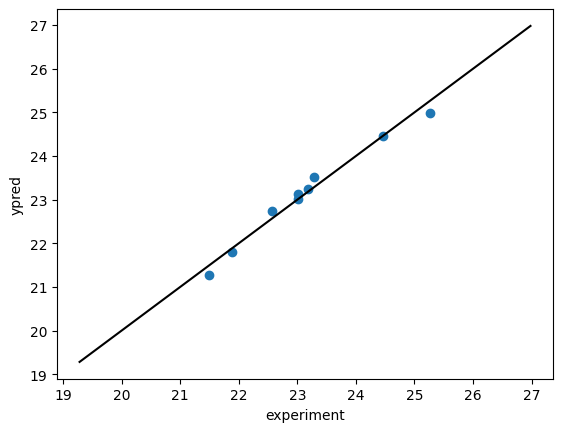

In [ ]:
ypred=res1.predict(x)
plt.scatter(results['y'],ypred)
x=np.linspace(min(ypred)-2,max(ypred)+2,101)

plt.plot(x,x,'k-') # identity line

plt.ylabel('ypred')
plt.xlabel('experiment')


Within the range of our variables, we have a good description of our experiment.

This leaves with the first order model: ybar = 23.1974 + 0.6235T + 0.8779p +0.2227A (note that there is a randomness in the experimental values, your model might not be the same as mine)  

So, now, for any T, p and A, we can predict y.

If we move 0.6235 steps in the direction of T, 0.8779 in the direction of p, and 0.2227 in the direction of pH and A, this will be the direction of steepest ascent. All we know is that this flat surface is one side of the "hill" forming our maxima.

With the method of steepest descent, we can now start marching up the hill taking additional measurements at each (T,pH, A) until the response starts to decrease. If we start at 0 (in coded units), then we can do series of single experiments as suggested by the model on this path up the hill of the steepest ascent. At all points, we can compare how the model performs and calcualte an error. When the error is to large, we need to repeat the DoE and create a new model. The stepsize is choosen based on our experience. If we do not have that, a suitable way is to perform a few experiment with large steps in the beginning, and then make the step size smaller when we now we are closer to the maxima.



The box below performs a march in the direction of the steepest ascent wiht stepsize delta_in_T. The number of experiments is nexp.

In [ ]:
max_y_index = results['y'].idxmax()
real_delta_in_T = 1
nexp=5
Origin = [results['T'].iloc[max_y_index], results['p'].iloc[max_y_index], results['A'].iloc[max_y_index]]
coeff= res1.params

# Calculate the coded step size for a real temperature step of 1
coded_delta_in_T = real_delta_in_T / inputs_df.loc['T']['span']

delta=[coded_delta_in_T, coded_delta_in_T*coeff[2]/coeff[1], coded_delta_in_T*coeff[3]/coeff[1] ]
delta_real=[inputs_df.loc['T']['span']*delta[0],inputs_df.loc['p']['span']*delta[1],inputs_df.loc['A']['span']*delta[2]]
marchT=[Origin[0]];marchp=[Origin[1]];marcha=[Origin[2]]


for i in range(0,nexp):
    marchT.append(Origin[0]+(i+1)*(delta[0]))
    marchp.append(Origin[1]+(i+1)*(delta[1]))
    marcha.append(Origin[2]+(i+1)*(delta[2]))

March=pd.DataFrame({'T':marchT, 'p':marchp, 'A':marcha})
ypred=res1.predict(March)

March['ypred']=ypred
March

/tmp/ipython-input-796970512.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta=[coded_delta_in_T, coded_delta_in_T*coeff[2]/coeff[1], coded_delta_in_T*coeff[3]/coeff[1] ]


,T,p,A,ypred
0,1.000000,1.000000,1.000000,24.980786
1,1.666667,1.791180,1.237747,26.209449
2,2.333333,2.582361,1.475495,27.438112
3,3.000000,3.373541,1.713242,28.666775
4,3.666667,4.164721,1.950990,29.895438
5,4.333333,4.955902,2.188737,31.124101


Then, we do do the real experiments:

In [ ]:
# Lets do the real experiment
#assume we take steps in T

Origin_real=[results['Temperature'].iloc[max_y_index], results['pH'].iloc[max_y_index], results['Amount'].iloc[max_y_index]]
marchT_real=[Origin_real[0]];marchp_real=[Origin_real[1]];marcha_real=[Origin_real[2]]

for i in range(1,len(March)):
    marchT_real.append(Origin_real[0]+(i+1)*(delta_real[0]))
    marchp_real.append(Origin_real[1]+(i+1)*(delta_real[1]))
    marcha_real.append(Origin_real[2]+(i+1)*(delta_real[2]))

March_real=pd.DataFrame({'Temperature':marchT_real, 'pH':marchp_real, 'Amount':marcha_real})

resp=[]
for i in range(len(March_real)):
   X=[March_real.Temperature[i], March_real.pH[i],March_real.Amount[i]]
   resp.append(experiment(X))
March_real['y_real']=resp
March_real

,Temperature,pH,Amount,y_real
0,23.0,5.400000,16.600000,25.036374
1,25.0,5.716472,16.980396,28.876745
2,26.0,5.874708,17.170594,31.699104
3,27.0,6.032944,17.360792,35.045682
4,28.0,6.191180,17.550990,39.345113
5,29.0,6.349416,17.741187,43.841758


we see that the direction of steepest descent takes in the right direction, but the model deviate strongly with the experiment. We can also plot the data:

and plot the results:

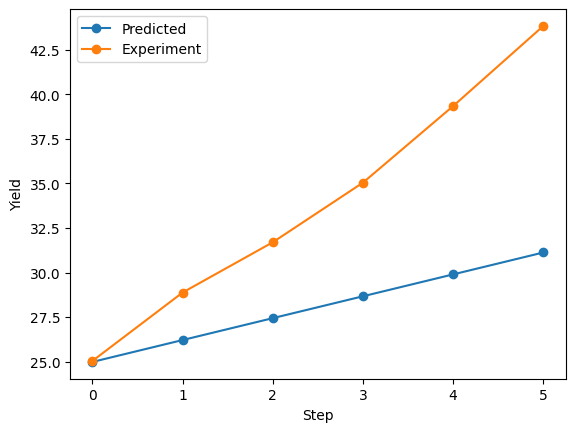

In [ ]:
March['ypred'].plot(marker='o', label='Predicted')
March_real['y_real'].plot(marker='o', label='Experiment')
plt.xlabel('Step')
plt.ylabel('Yield')
plt.legend()
plt.show()

Based on this plot, we make a new DoE around our maximum. First we identify the experimental settings for the maximum in our experiments followed by defining new high and low points for our variables.

In [ ]:
max=March_real['y_real'].sort_values(ascending=False).index[0]
# second try
dT=3
dp=2
dA=2
#create list of data for high and low.
dat = [('T',March_real.iloc[max].Temperature-dT, March_real.iloc[max].Temperature, March_real.iloc[max].Temperature+dT),
        ('p', March_real.iloc[max].pH-dp, March_real.iloc[max].pH,  March_real.iloc[max].pH+dp),
        ('A',March_real.iloc[max].Amount-dA, March_real.iloc[max].Amount, March_real.iloc[max].Amount+dA )]

Then we redo the process again...

In [ ]:
inputs_labels = {'T' : 'Temperature',
                 'p' : 'pH',
                 'A':'Amount'}



# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df


,low,center,high,label
index,,,,
T,26.000000,29.000000,32.000000,Temperature
p,4.349416,6.349416,8.349416,pH
A,15.741187,17.741187,19.741187,Amount


In [ ]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

# inputs_df = inputs_df.drop(['average','span'],axis=1) # Keep average and span columns

inputs_df

,low,center,high,label,average,span,encoded_low,encoded_center,encoded_high
index,,,,,,,,,
T,26.000000,29.000000,32.000000,Temperature,29.000000,3.0,-1.0,0.0,1.0
p,4.349416,6.349416,8.349416,pH,6.349416,2.0,-1.0,0.0,1.0
A,15.741187,17.741187,19.741187,Amount,17.741187,2.0,-1.0,0.0,1.0


In this step, we add a few more centerpoints to evaluate the experimental error in our setup.

In [ ]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1], [-1,1]))
encoded_inputs
for i in range(0,5):
    encoded_inputs.append((0,0,0))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0)]

In [ ]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['T','p', 'A']
results

,T,p,A
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1
8,0,0,0
9,0,0,0


In [ ]:
real_experiment = results
var_labels = []
for var in ['T','p', 'A']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),
        axis=1)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Temperature,pH,Amount
0,26.0,4.349416,15.741187
1,32.0,4.349416,15.741187
2,26.0,8.349416,15.741187
3,32.0,8.349416,15.741187
4,26.0,4.349416,19.741187
5,32.0,4.349416,19.741187
6,26.0,8.349416,19.741187
7,32.0,8.349416,19.741187
8,29.0,6.349416,17.741187
9,29.0,6.349416,17.741187


and finally perform the experiments:

In [ ]:
resp=[]
for i in range(len(real_experiment.index)):
   X=[real_experiment.Temperature[i], real_experiment.pH[i],real_experiment.Amount[i]]
   resp.append(experiment(X))

results['y']= resp
results

,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,26.0,4.349416,15.741187,21.615717
1,1,-1,-1,32.0,4.349416,15.741187,23.256292
2,-1,1,-1,26.0,8.349416,15.741187,80.373208
3,1,1,-1,32.0,8.349416,15.741187,51.861261
4,-1,-1,1,26.0,4.349416,19.741187,22.029737
5,1,-1,1,32.0,4.349416,19.741187,23.846397
6,-1,1,1,26.0,8.349416,19.741187,84.377786
7,1,1,1,32.0,8.349416,19.741187,50.585701
8,0,0,0,29.0,6.349416,17.741187,43.739347
9,0,0,0,29.0,6.349416,17.741187,43.647584


And we fit a linear model using statmodels

In [ ]:
y2 = results['y']
xlabs=['T','p','A']
x = results[xlabs]


res2 = smf.ols(formula='y ~ T + p + A', data=results).fit()

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     23.58
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           0.000134
Time:                        06:39:09   Log-Likelihood:                -42.793
No. Observations:                  13   AIC:                             93.59
Df Residuals:                       9   BIC:                             95.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.4072      2.169     20.475      0.000      39.501      49.314
T             -7.3558      2.765     -2.661      0.026     -13.610      -1.101
p             22.0562      2.765      7.978      0.000      15.802      28.311
A              0.4666      2.765      0.169      0.870      -5.788       6.721
==============================================================================
Omnibus:                        2.065   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.356   Jarque-Bera (JB):                0.956
Skew:                           0.169   Prob(JB):                        0.620
Kurtosis:                       1.715   Cond. No.                         1.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0, 'experiment')

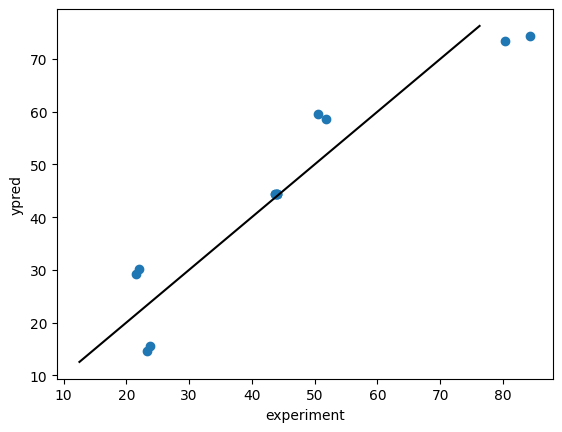

In [ ]:
ypred=res2.predict(x)
plt.scatter(results['y'],ypred)
xn=np.linspace(np.min(ypred)-2,np.max(ypred)+2,101)

plt.plot(xn,xn,'k-') # identity line

plt.ylabel('ypred')
plt.xlabel('experiment')

Here we see that the model is not any longer well approximated with a linear fit. This implieas that we most likely identified our maxima.

By doing the repeated experiments, we now also have the possibility to evalueate the experimental errror:

In [ ]:
exp_repeat=results['y'][8:13]
print('mean=', exp_repeat.mean(), 'std=', exp_repeat.std(), 'var=', exp_repeat.var())

mean= 43.86956954294913 std= 0.16411770831977449 var= 0.026934622184134574


As we see, the experomental error is small. We keep this values in mind when going to the next step, which is to use a higher order model.

When ready, use higher order model...


In [ ]:
res3 = smf.ols(formula='y ~ T + p + A + T:p +T:A + p:A + I(T**2) + I(p**2)', data=results).fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     909.0
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           1.87e-07
Time:                        06:40:05   Log-Likelihood:                -10.501
No. Observations:                  13   AIC:                             37.00
Df Residuals:                       5   BIC:                             41.52
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.8696      0.391    112.096      0.0

Text(0.5, 0, 'experiment')

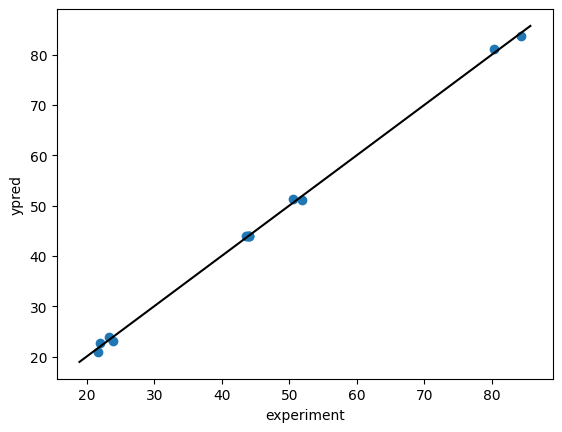

In [ ]:
ypred=res3.predict(x)
plt.scatter(results['y'],ypred)
xn=np.linspace(np.min(ypred)-2,np.max(ypred)+2,101)

plt.plot(xn,xn,'k-') # identity line

plt.ylabel('ypred')
plt.xlabel('experiment')

We note that the maxima lies in a corner of our box, and our model has limited validity outside the box. Therefore, we expand around the maximum and perform a DoE using a Latin Hypercube design. We use the input variables as the left lower corner and generate new data points:

In [ ]:
!pip install doepy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for diversipy: filename=diversipy-0.9-py3-none-any.whl size=27698 sha256=9e51dad61516b8f331249766ece7f054589e3a3bf01dcebc058ae427e998cc81
  Stored in directory: /root/.cache/pip/wheels/0c/82/74/0402038c9a5549102f03f2b84b6c86c9d5dce26657cf4d5d1c
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=e7e449614ada0a179cefffcc3fd14655ea2514a2b9584a502bc6da894d76e8c4
  Stored in directory: /root/.cache/pip/wheels/96/b9/5d/1138ea8c8f212bce6e97ae58847b7cc323145b3277f2129e2b
Successfully built diversipy pyDOE


In [ ]:
results


,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,26.0,4.349416,15.741187,21.615717
1,1,-1,-1,32.0,4.349416,15.741187,23.256292
2,-1,1,-1,26.0,8.349416,15.741187,80.373208
3,1,1,-1,32.0,8.349416,15.741187,51.861261
4,-1,-1,1,26.0,4.349416,19.741187,22.029737
5,1,-1,1,32.0,4.349416,19.741187,23.846397
6,-1,1,1,26.0,8.349416,19.741187,84.377786
7,1,1,1,32.0,8.349416,19.741187,50.585701
8,0,0,0,29.0,6.349416,17.741187,43.739347
9,0,0,0,29.0,6.349416,17.741187,43.647584


In [ ]:
from doepy import read_write, build
lhs=build.space_filling_lhs(
{'Temperature':[23.5, 27],
'pH':[8.0, 8.6],
 'Amount': [15, 16]},
num_samples = 15
)

we perform the experiments

In [ ]:
resp=[]
results_lhs=lhs
for i in range(len(lhs)):
  resp.append(experiment([lhs['Temperature'][i],lhs['pH'][i], lhs['Amount'][i]]))

results_lhs['Response']=resp
results_lhs

,Temperature,pH,Amount,Response
0,24.00,8.428571,15.357143,78.151643
1,25.75,8.042857,15.285714,78.002791
2,24.75,8.385714,15.642857,81.025170
3,23.50,8.300000,15.857143,81.031998
4,26.75,8.128571,16.000000,82.773041
5,25.00,8.557143,15.928571,79.085350
6,24.25,8.471429,15.000000,75.675615
7,27.00,8.257143,15.142857,75.029571
8,26.25,8.171429,15.214286,77.948530
9,25.50,8.085714,15.714286,81.708713


In [ ]:
res4 = smf.ols(formula='Response ~ Temperature + pH + Amount + I(Temperature**2) + I(pH**2) + I(Amount**2)', data=results_lhs).fit()
print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     11.82
Date:                Wed, 01 Oct 2025   Prob (F-statistic):            0.00134
Time:                        06:46:11   Log-Likelihood:                -18.481
No. Observations:                  15   AIC:                             50.96
Df Residuals:                       8   BIC:                             55.92
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1906.0124   1

In [ ]:
res4 = smf.ols(formula='Response ~ Temperature + pH + Amount + Temperature:pH + I(Temperature**2) + I(pH**2) + I(Amount**2)', data=results_lhs).fit()
print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     189.3
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           1.94e-07
Time:                        06:46:27   Log-Likelihood:                 3.7174
No. Observations:                  15   AIC:                             8.565
Df Residuals:                       7   BIC:                             14.23
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5352.9825    

With this model, we can find the optimal position visually by plotting the fitted function. Here I use a brute force method just using very many random variables. Can you use another way?

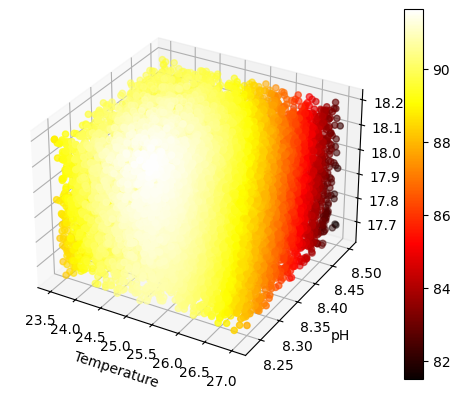

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

{'Temperature':[25.5, 27],
'pH':[8.2307, 8.5],
 'Amount': [17.652903, 18.2]},

Temperature = np.random.uniform(23.5, 27, 15000)
pH = np.random.uniform(8.2307, 8.5, 15000)
Amount = np.random.uniform(17.652903, 18.2, 15000)


data=pd.DataFrame({'Temperature':Temperature, 'pH':pH, 'Amount':Amount})

c = res4.predict(data)
data['ypred']=c
img = ax.scatter(Temperature, pH, Amount, c=c, cmap=plt.hot())
fig.colorbar(img)

ax.set_xlabel('Temperature')
ax.set_ylabel('pH')
ax.set_zlabel('Amount')

plt.show()

and find the input values for the maximum yeld as obtained from the model:

In [ ]:
data['ypred'].idxmax()
data.iloc[data['ypred'].idxmax()]

,1322
Temperature,25.252679
pH,8.232550
Amount,18.191924
ypred,91.626887


The last test is to perform the experiment that validate our finding:

In [ ]:
print('Temperature=', data.iloc[data['ypred'].idxmax()]['Temperature'], 'pH=', data.iloc[data['ypred'].idxmax()]['pH'], 'Amount=', data.iloc[data['ypred'].idxmax()]['Amount'])
experiment([data.iloc[data['ypred'].idxmax()]['Temperature'],data.iloc[data['ypred'].idxmax()]['pH'],data.iloc[data['ypred'].idxmax()]['Amount']])

Temperature= 25.25267937735985 pH= 8.232549817403985 Amount= 18.19192399498795


np.float64(93.78139087943293)

Here, I'll guess that we are satisfied with this result. We have used the response surface model and found a maximum according to our model. Depending on the "cost" of performing experiments, we can of course continue to refine our model with more experimental data, but for the case of this tutorial, we stop here.